In [8]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
path="../../../ukb/data/"

'''
Helper function to find out columns containing specific text
'''
def findcols(df,text):
    return [col for col in df.columns if text in col]

In [9]:
'''
set of variables removed as noise
'''

drop_ohc_cols=['death_date','age_at_death_f40007', 'date_of_death_f40000', 'death_record_format_f40018',
 'death_record_origin_f40020', 'description_of_cause_of_death_f40010',
'date_of_alzheimers_disease_report_f42020', 'source_of_alzheimers_disease_report_f42021',
'date_of_all_cause_dementia_report_f42018', 'date_of_frontotemporal_dementia_report_f42024', 'date_of_vascular_dementia_report_f42022',
 'source_of_all_cause_dementia_report_f42019', 'source_of_frontotemporal_dementia_report_f42025', 
 'source_of_vascular_dementia_report_f42023','Age_Today']

exc_ohc_cols=['eid','death']

disease_vars=['EPIL_bef','DIAB_bef','CERVASC_bef','CERVASCALL_bef','STROKE_bef','AD','EPIL','DIAB','CERVASC','CELIAC','PD']

In [31]:
def onehotencoder(df,dropcols,exccols,maxrecs=12,mincount=0.8,minctcts=0.8,nodrop=0):
    
    if nodrop==0:
        df1=df.drop(columns=np.append(dropcols,exccols),axis=0)
    else:
        df1=df.copy()
   
    
    print(r'Total variables = %0.0f ' % (df1.shape[1]-1))
    
    ohe_cols=\
    [col for col in df1.columns if len(df1[col].value_counts())<maxrecs and df1[col].count()/df1[col].shape[0]>mincount]
    
    print(r'Total ohe variables = %0.0f ' % (len(ohe_cols)))
        
    df_ohe_cols=df1[ohe_cols]
    
    cts_cols=[col for i,col in enumerate(df1.columns) if re.search(str(df1.dtypes[i]),'float64|int')
             #and len(df1[col].value_counts())>=maxrecs 
              and 
              df1[col].count()/len(df1[col])>minctcts]
    
    print(r'Total cts variables = %0.0f ' % (len(cts_cols)))
    
    df_ctsvars=df1[cts_cols]
    
    df_ctsvars['eid']=df['eid']
    
    for col in df_ohe_cols.columns:
        df_ohe_cols[col][pd.isnull(df_ohe_cols[col])]='Unknown'
    df_out=pd.get_dummies(df_ohe_cols, prefix=df_ohe_cols.columns,
               columns=df_ohe_cols.columns)
    
    print(r'Total ohe variables post trans = %0.0f ' % (df_out.shape[1]-1))
    
    exccols2=[col for col in df.columns if col in exccols]
    
    df_out[exccols2]=df[exccols2]
    
    df_full=pd.merge(df_out,df_ctsvars,on='eid',how='left')    
    
    
    print(r'Total variables out = %0.0f ' % (df_full.shape[1]-1))
    
    return df_full

def rebalage(df,min_age=75,max_age=83,disease="AD",diagcutoff=2,sampleratio=1,death='death',agematch=1):
    
    df['Age_Today']=df['Age_Today'].round()
    rule_age=(df['Age_Today']>=min_age)&(df['Age_Today']<=max_age)
    rule_dis=(df[disease]==1)
    rule_cont=(df[disease]==0)
    rule_death=(df[death]!=1)
    rule_diag_cut=(df['years_bef_diag'+disease]>diagcutoff)
    
    rule_nonnull=pd.notnull(df['eid'])
    mask_dis=rule_age&rule_dis&rule_diag_cut&rule_nonnull
    mask_cont=rule_age&rule_cont&rule_death&rule_nonnull
    case=df['eid'][mask_dis]
    
    if agematch==1:
        #find matches by age between disease and control - do we want age today or age attended?
        dis_age=pd.DataFrame(df[mask_dis].groupby('Age_Today').size()).reset_index()
        dis_age.columns=['Age_Today','age_recs']

        cont_age=pd.merge(df[['eid','Age_Today']][mask_cont],dis_age,on='Age_Today',how='inner')
        cont_age=pd.DataFrame(cont_age.groupby('Age_Today').\
        apply(lambda x: x['eid'].sample(x['age_recs'].max()*sampleratio,replace=False))).reset_index()
        cont_age=pd.merge(cont_age,dis_age,on='Age_Today',how='inner')
        
        cont_age['set_score']=cont_age.groupby(['Age_Today']).cumcount()/cont_age['age_recs']
        cont_age['set']=cont_age['set_score'].apply(np.floor)

        cont_age=cont_age[['eid','set']]
        control=cont_age['eid']
        
        
    else:
        
        control=df['eid'][mask_cont]
        cont_age=control.copy()
        cont_age['set']=1
    
    
    
    eids=pd.concat([case,control],axis=0)
    
    return eids,cont_age


def maskdfs(df,name):
    mask_df=(eid_df['eid'].isin(df['eid']))
    eid_df[name]=0
    eid_df[name][mask_df]=1
    return eid_df

def combinedata(eids,sets,df1,df2):
    df1=df1[(df1['eid'].isin(eids))]
    df2=df2[(df2['eid'].isin(eids))]
    df_out=pd.merge(df1,df2,on='eid',how='inner')
    df_out=pd.merge(df_out,sets[['eid','set']],on='eid',how='left')
    return df_out

def mergewidedf(df1,df2,feats=['Age_Today'],depvar='AD'):
    #df1.sort_values(by='eid',inplace=True)
    
    #df2.sort_values(by='eid',inplace=True)
    print(df2.shape)
    df1_temp=pd.merge(df1[['eid']],df2[np.append('eid',feats)], on='eid',how='left')
    print(df1_temp.shape)
    #df1_temp.sort_values(by='eid',inplace=True)
    df1[feats]=df1_temp[feats]
    df1=df1[pd.notnull(df1[depvar])]
    return df1

In [11]:
ukb_tp0=pd.read_pickle('%s%s' % (path,'ukb_tp0.p'))
ukb_tp_brain=pd.read_pickle('%s%s' % (path,'ukb_brain.p'))
diseases_bin=pd.read_pickle('%s%s' % (path,'ukb_disease_labels.p'))

In [12]:
ukb_tp0.shape

(502523, 1522)

In [13]:
mod_riskfactors=pd.read_csv('%s%s' % (path,"Modifiableriskfactors.csv"))
modriskfactors=[col for col in ukb_tp0.columns if col in np.asarray(mod_riskfactors['variable']) 
                or re.search('eid|Genotype|qual',col)]

In [30]:
qualmap={'None of the above':0,'Prefer not to answer':0,'O levels/GCSEs or equivalent':1,\
'NVQ or HND or HNC or equivalent':2,'NVQ or HND or HNC or equivalent' :3,\
'NVQ or HND or HNC or equivalent':4,'CSEs or equivalent':5,\
'Other professional qualifications eg: nursing, teaching':6,'A levels/AS levels or equivalent':7,\
'College or University degree':8 }   
ukb_tp0['qualif_score']=ukb_tp0['qualifications_f6138'].map(qualmap)
ukb_tp0['qualif_score'][pd.isnull(ukb_tp0['qualif_score'])]=0


#### Filter to remove insufficiently populated variables

In [17]:
diseases_bin['eid']=diseases_bin['n_eid']
APOEADmask=((diseases_bin['APOE_AD']==1))
diseases_bin_APOE=diseases_bin[~APOEADmask]
mask_coeliac=pd.notnull(ukb_tp0['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068'])
ukb_tp0_surv=ukb_tp0[(mask_coeliac)]


In [18]:
ukb_tp0_mod=ukb_tp0[modriskfactors]

In [32]:
ukb_tp0_ohc=onehotencoder(ukb_tp0,dropcols=drop_ohc_cols,exccols=exc_ohc_cols,maxrecs=9,mincount=0.8)

Total variables = 1505 
Total ohe variables = 358 
Total cts variables = 189 
Total ohe variables post trans = 1464 
Total variables out = 1655 


In [33]:
findcols(ukb_tp0_ohc,'qual')

['usual_side_of_head_for_mobile_phone_use_f1150_Equally left and right',
 'handedness_chiralitylaterality_f1707_Use both right and left hands equally',
 'qualifications_f6138_A levels/AS levels or equivalent',
 'qualifications_f6138_CSEs or equivalent',
 'qualifications_f6138_College or University degree',
 'qualifications_f6138_NVQ or HND or HNC or equivalent',
 'qualifications_f6138_None of the above',
 'qualifications_f6138_O levels/GCSEs or equivalent',
 'qualifications_f6138_Other professional qualifications eg: nursing, teaching',
 'qualifications_f6138_Prefer not to answer',
 'qualifications_f6138_Unknown',
 'qualif_score_0.0',
 'qualif_score_1.0',
 'qualif_score_4.0',
 'qualif_score_5.0',
 'qualif_score_6.0',
 'qualif_score_7.0',
 'qualif_score_8.0',
 'affymetrix_quality_control_metric_clustercr_f22025',
 'affymetrix_quality_control_metric_dqc_f22026',
 'qualif_score']

In [20]:
ukb_tp0_ohc_mod=onehotencoder(ukb_tp0_mod,dropcols='',exccols=exc_ohc_cols,maxrecs=15,mincount=0.8,nodrop=1)

Total variables = 109 
Total ohe variables = 60 
Total cts variables = 47 
Total ohe variables post trans = 415 
Total variables out = 463 


In [11]:
diseases_bin['death'].sum()

30435.0

In [34]:
AD_eids_full,cont_age_full=rebalage(diseases_bin,min_age=70,max_age=83,disease="AD",
                                     diagcutoff=2,sampleratio=28,agematch=0)
AD_model_full=combinedata(AD_eids_full,cont_age_full,ukb_tp0_ohc,
                          diseases_bin[np.append(['eid','Age_Today'],disease_vars)])
AD_model_full.to_pickle('%s%s' % (path,'AD_model_full70.p'))

In [389]:
AD_eids_full,cont_age_full=rebalage(diseases_bin,min_age=75,max_age=83,disease="AD",
                                     diagcutoff=2,sampleratio=28,agematch=0)
AD_model_full=combinedata(AD_eids_full,cont_age_full,ukb_tp0_ohc,
                          diseases_bin[np.append(['eid','Age_Today'],disease_vars)])
AD_model_full.to_pickle('%s%s' % (path,'AD_model_full75.p'))

In [10]:
AD_eids_full_mod,cont_age_full_mod=rebalage(diseases_bin,min_age=70,max_age=83,disease="AD",
                                     diagcutoff=2,sampleratio=28,agematch=0)
AD_model_full_mod=combinedata(AD_eids_full_mod,cont_age_full_mod,ukb_tp0_ohc_mod,
                          diseases_bin[np.append(['eid','Age_Today'],disease_vars)])
AD_model_full_mod.to_pickle('%s%s' % (path,'AD_model_full70_mod.p'))

In [390]:
AD_eidsage,cont_age=rebalage(diseases_bin,min_age=75,max_age=83,disease="AD",
                                     diagcutoff=2,sampleratio=23,agematch=1)
AD_modelage=combinedata(AD_eidsage,cont_age,ukb_tp0_ohc,diseases_bin[np.append(['eid','Age_Today'],disease_vars)])
AD_modelage.to_pickle('%s%s' % (path,'AD_modelage.p'))

In [36]:
APOE_eidsage,APOE_cont_age=rebalage(diseases_bin_APOE,min_age=75,max_age=83,disease="AD",
                                     diagcutoff=2,sampleratio=28,agematch=1)
APOE_modelage=combinedata(APOE_eidsage,APOE_cont_age,ukb_tp0_ohc,diseases_bin_APOE[np.append(['eid','Age_Today'],disease_vars)])
APOE_modelage.to_pickle('%s%s' % (path,'APOE_modelage.p'))

In [351]:
PD_eids_full,cont_age_full_PD=rebalage(diseases_bin,min_age=70,max_age=83,disease="PD",
                                     diagcutoff=2,sampleratio=28,agematch=0)
PD_model_full=combinedata(PD_eids_full,cont_age_full_PD,ukb_tp0_ohc,
                          diseases_bin[np.append(['eid','Age_Today'],disease_vars)])
PD_model_full.to_pickle('%s%s' % (path,'PD_model_full70.p'))

In [360]:
diseases_bin[(diseases_bin['Age_Today']>=75)].shape

(129070, 63)

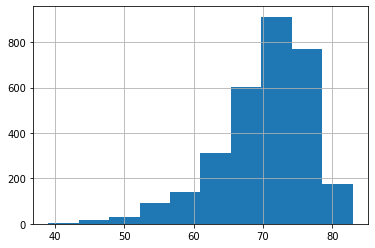

In [361]:
diseases_bin['Age_Diag_PD'][(diseases_bin['PD']==1)].hist()


73.22005669693428
0.4202832343535861
8.601969679414617
2.547537661059168


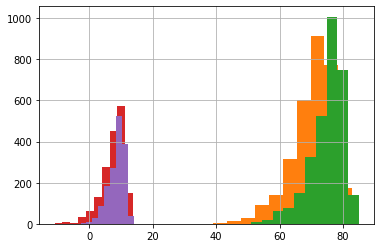

In [355]:

print(diseases_bin['Age_Diag_AD'][(diseases_bin['AD']==1)].mean())

print(diseases_bin[(diseases_bin['AD']==1)&(diseases_bin['Age_Diag_AD']>=75)].shape[0]/
      diseases_bin[(diseases_bin['AD']==1)].shape[0])

diseases_bin['Age_Today'][(diseases_bin['PD']==1)].hist()
diseases_bin['years_bef_diagPD'][(diseases_bin['Age_Today']>75)].hist()
diseases_bin['years_bef_diagAD'][(diseases_bin['Age_Today']>75)].hist()
print(diseases_bin['years_bef_diagAD'][(diseases_bin['Age_Today']>75)].mean())
print(diseases_bin['years_bef_diagAD'][(diseases_bin['Age_Today']>75)].std())

In [37]:
#Set of eids labelled

eid_df=pd.DataFrame(ukb_tp0['eid'])
eid_df=maskdfs(APOE_modelage,'APOE_eids')
eid_df=maskdfs(AD_modelage,'Age_eids')
eid_df=maskdfs(AD_model_full,'o75_eids')

eid_df.to_pickle('%s%s' % (path,'eid_df.p'))